In [23]:
435895

435895

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Tarefa 4 - Decision Trees, Random Forest and K-Means
Fourth assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using decision trees and random forests to solve a real-world problem in classification and delve into the world of unsupervised learning by implementing the K-means algorithm. Students will also get used to generating important plots during training to analyse the models' behaviour. 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).
* Please try to not use any LLM-generated code. This coursework is designed for you to learn crucial concepts. Once you master them, then using LLMs become much easier.

## Notebook Overview:

1. [Decision Trees](#Decision_Trees) (30%)
2. [Random Forest](#Random_Forest) (30%)
3. [K-Means](#K-Means) (30%)

### Decision_Trees
## Part 1 - Decision Trees for Classification (value: 30%)

In this exercise, you will implement a decision tree for classifying whether the income of a person exceeds $50k/yr based on census data (adult_census_subset.csv in ECLASS). You will use the Information Gain based on the Gini Index as the impurity measure as the splitting criterion. The maximum depth and the minimum number of instances per leaf will be your stopping criteria. Be aware that some of the variables in this dataset are nominal (or categorical).

To complete this exercise, you will write code to build a decision tree for this problem: 

1. Dataset Splitting:
    - Load the provided dataset into your code.
	- Split the dataset into three sets: training, validation, and testing, with a 70/15/15 ratio, respectively. 
2. Implement a function to learn Decision Trees – the main conceptual steps are detailed below:
	- Initialize an empty decision tree.
	- Implement a recursive function to build the decision tree:
        - The stopping conditions for the recursive function are [note: satisfying only one of them is sufficient to stop the recursion]:
            - If the maximum depth is reached, stop growing the tree and create a leaf node with the frequency of the positive class for the remaining instances.
            - If the number of instances at a leaf node is less than the minimum number of instances per leaf, create a leaf node with the frequency of the positive class for those instances.
        - Your code will calculate the Information Gain (based on the Gini Index) for each possible value of each attribute and choose the attribute and value that maximizes the Information Gain (explanation below).
        - Your code will create a new internal node using the chosen attribute and value.
        - Your code will recursively call the build function on each subset of instances created by the split.
3. Implement a classification function. Implement a function to classify new instances using the decision tree:
	- For each instance, traverse the decision tree by comparing its attribute values to the decision nodes and move down the tree based on the attribute values until a leaf node is reached.
	- Return the frequency of the positive class that is associated with the leaf node as the prediction for the instance.
4. Run your algorithm and evaluate its performance:
	- Call the build function with the training set to construct the decision tree. You will vary the maximum depth and minimum number of instances per leaf to observe their effects on the decision tree performance. You will use the training set to learn the tree and the validation set using the Area Under the Roc Curve (AUROC) to find the optimal parameters. Try only shallow trees of a depth not deeper than 10, and min_instances not smaller than 10. If you try more extreme values, the training time could be too much.
	- Build a decision tree using the training + validation sets with the best combination of parameters.
	- Calculate the accuracy (threshold: 0.5) and AUROC of the decision tree in the testing set and report them.

To select the best split at each node you will use the Information Gain based on the Gini Index. The Gini Index measures the impurity of a node in a decision tree. To calculate the Information Gain based on the Gini Index, follow these steps [note: the same is explained in the slides for the case of entropy]:
- For each potential split (feature and value):
	- Calculate the Gini Index for node m (before any splits) using the class distribution within the node, using the following formula:
        - $G_m=\sum_{k=1}^K (\hat{p}_{mk} (1-\hat{p}_{mk})$, where $\hat{p}_{mk}$ represents the proportion of instances in the node $m$ that belong to class $k$.
	- Calculate the Gini Index for each possible outcome. This involves the following steps:
        - Split the data based on the attribute's possible outcomes.
        - Calculate the Gini index for each resulting subset using the same formula as in step a.
	- Calculate the weighted Gini index by summing up the Gini indexes of each subset, weighted by the proportion of instances it represents in the original node. The formula for the weighted Gini index ($W$) is as follows:
        - $W_V=\sum_v^V \frac{|S_v|}{|S|} G_{S_v} $ where $S_v$ is the node after the split and the sum iterates over all the children nodes; $|S_v|$ represents the cardinality of the node and $|S|$ the cardinality of the node before splitting; $G_{S_v}$ represents the Gini index of the node.
	- Calculate the information gain by subtracting the weighted Gini index obtained in step c. from the Gini index of the current node. The formula is as follows:
        - $InformationGain=G_{node}-W_V$



---



## Solution.

### Spliting the Data.

In [2]:
# --- Spliting the Data --- #

ads_df = pd.read_csv("adult_census_subset.csv")
X1 = ads_df[['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']]
Y1 = ads_df[['income']]
random_state = 9
X_train1, X_vt1, Y_train1, Y_vt1 = train_test_split(X1, Y1, test_size=0.3, random_state=random_state)
X_test1, X_validation1, Y_test1, Y_validation1 = train_test_split(X_vt1, Y_vt1, test_size=0.5, random_state=random_state)

X_train_set1 = pd.concat([X_train1, X_validation1])
Y_train_set1 = pd.concat([Y_train1, Y_validation1])



In [3]:
print(f"Training Size: {len(X_train1) / len(X1)}")
print(f"Validation Size: {len(X_validation1) / len(X1)}")
print(f"Test Size: {len(X_test1) / len(X1)}")

Training Size: 0.6986754966887417
Validation Size: 0.15066225165562913
Test Size: 0.15066225165562913


### CART

In [4]:
class Node:
    def __init__(self, set_index, depth):
        self.set_index = set_index 
        self.question = None
        self.left_child = None
        self.right_child = None
        self.gini = 0
        self.depth = depth
        self.label = None
        self.prob_classes = {}

In [5]:
class Question:
    def __init__(self, feature: str, operator: str, value: str or int):  # type: ignore
        """Inicia a o objeto
        Args:
            feature (str): Feature que participará da pergunta
            operator (str): Operador de comparação, ie. ">=", "==", ...
            value (str or int): Valor a ser comparado
        """
        self.feature = feature
        self.operator = operator
        self.value = value
    
    def __repr__(self):
        return f"{self.feature} {self.operator} {self.value}"
    

In [6]:
class Cart:
    def __init__(self, max_depth, min_node_instances):
        self.max_depth = max_depth  # Profundidade máxima da árvore
        self.min_node_instances = min_node_instances  # Mínimo de instâncias por nó
        self.root = Node([], 0)  # Nó raiz inicial

    def match(self, question, sample):
        # Avalia se uma amostra satisfaz uma pergunta (condição)
        if question.operator == "==":
            return sample[question.feature] == question.value
        elif question.operator == "<=":
            return sample[question.feature] <= question.value

    def gini_coeficient(self, set_index):
        # Calcula o coeficiente de Gini para os índices fornecidos
        if len(set_index) == 0:
            return 0
        counts = self.Y_train.loc[set_index].value_counts()
        proportions = counts / len(set_index)
        gini = 1 - np.sum(proportions ** 2)
        return gini

    def do_split(self, node, question):
        # Realiza a divisão de um nó com base na pergunta
        all_indices = node.set_index
        features_values = self.X_train.loc[all_indices, question.feature]

        if question.operator == "==":
            mask = (features_values == question.value)
        elif question.operator == "<=":
            mask = (features_values <= question.value)

        left_index = node.set_index[mask]
        right_index = node.set_index[~mask]

        # Calcula o ganho de Gini com a divisão
        gain = node.gini - len(left_index) * self.gini_coeficient(left_index) / len(node.set_index) - len(right_index) * self.gini_coeficient(right_index) / len(node.set_index)

        return gain, np.array(left_index), np.array(right_index)

    def select_question(self, node):
        # Seleciona a melhor pergunta para dividir o nó atual
        best_gain = 0
        best_question = None
        best_left_index = None
        best_right_index = None
        
        y_node = self.Y_train.loc[node.set_index].squeeze()

        for feature in self.X_train.columns:
            x_node_feature = self.X_train.loc[node.set_index, feature]

            if x_node_feature.dtype == object:
                # Trata atributos categóricos
                for value in x_node_feature.unique():
                    question = Question(feature=feature, operator="==", value=value)
                    gain_new, left_index, right_index = self.do_split(node, question)
                    if gain_new > best_gain:
                        best_gain, best_question, best_left_index, best_right_index = gain_new, question, left_index, right_index

            else:
                # Trata atributos numéricos com otimização
                df_temp = pd.DataFrame({'feature': x_node_feature, 'label': y_node}).sort_values('feature')
                sorted_labels = df_temp['label'].values
                sorted_indices = df_temp.index.values

                right_counts = y_node.value_counts().to_dict()
                left_counts = {k: 0 for k in right_counts.keys()}

                n_right = len(sorted_labels)
                n_left = 0

                for i in range(len(sorted_labels) - 1):
                    label = sorted_labels[i]
                    n_left += 1
                    n_right -= 1
                    left_counts[label] += 1
                    right_counts[label] -= 1

                    current_val = sorted_labels[i]
                    next_val = sorted_labels[i+1]
                    if current_val == next_val:
                        continue

                    p_left = np.array(list(left_counts.values())) / n_left
                    gini_left = 1 - np.sum(p_left**2)

                    p_right = np.array(list(right_counts.values())) / n_right if n_right > 0 else 0
                    gini_right = 1 - np.sum(p_right**2)

                    gain_new = node.gini - (n_left / len(node.set_index)) * gini_left - (n_right / len(node.set_index)) * gini_right

                    if gain_new > best_gain:
                        best_gain = gain_new
                        threshold = (df_temp['feature'].iloc[i] + df_temp['feature'].iloc[i+1]) / 2
                        best_question = Question(feature=feature, operator="<=", value=threshold)
                        best_left_index = sorted_indices[:i+1]
                        best_right_index = sorted_indices[i+1:]

        return best_gain, best_question, best_left_index, best_right_index

    def recursive_growth(self, node):
        # Cresce a árvore recursivamente a partir do nó atual
        if node.gini == 0 or node.depth >= self.max_depth or len(node.set_index) <= self.min_node_instances:
            counts = self.Y_train.loc[node.set_index].value_counts()
            if not counts.empty:
                node.label = counts.idxmax()
                node.prob_classes = (counts / len(node.set_index)).to_dict()
            return

        best_gain, best_question, left_index, right_index = self.select_question(node)

        if best_gain == 0:
            # Evita recursão infinita se não houver ganho
            counts = self.Y_train.loc[node.set_index].value_counts()
            if not counts.empty:
                node.label = counts.idxmax()
                node.prob_classes = (counts / len(node.set_index)).to_dict()
            return

        node.question = best_question

        node.left_child = Node(left_index, node.depth + 1)
        node.left_child.gini = self.gini_coeficient(left_index)

        node.right_child = Node(right_index, node.depth + 1)
        node.right_child.gini = self.gini_coeficient(right_index)

        self.recursive_growth(node.left_child)
        self.recursive_growth(node.right_child)

    def fit(self, X_train, Y_train):
        # Treina a árvore com os dados de entrada
        self.X_train = X_train
        self.Y_train = Y_train

        self.root.set_index = self.X_train.index.to_numpy()
        self.root.gini = self.gini_coeficient(self.root.set_index)

        self.recursive_growth(self.root)

    def prediction_recursion(self, x, node):
        # Percorre a árvore até encontrar o nó folha para a amostra x
        if node.label != None:
            return node
        if self.match(node.question, x):
            return self.prediction_recursion(x, node.left_child)
        else:
            return self.prediction_recursion(x, node.right_child)

    def predic_probabilities(self, X_test, true_label=(1,)):
        # Retorna as probabilidades para o rótulo verdadeiro em cada amostra
        prob_classes = []
        for index in range(len(X_test)):
            leaft_node = self.prediction_recursion(X_test.iloc[index], self.root)
            probability = leaft_node.prob_classes.get(true_label, 0.0)
            prob_classes.append(probability)
        return prob_classes

    def predict(self, X_test):
        # Retorna os rótulos previstos para o conjunto de teste
        predictions = []
        for index in range(len(X_test)):
            leaf_node = self.prediction_recursion(X_test.iloc[index], self.root)
            predictions.append(leaf_node.label)
        return predictions


In [7]:
best_depth = 0  # Melhor profundidade encontrada
best_min_instances = 0  # Melhor número mínimo de instâncias no nó
best_score = 0  # Melhor AUC obtido

# Testa profundidades de 2 a 8
for depth in range(2, 9):
    # Testa diferentes valores mínimos de instâncias por nó
    for min_instances in [70, 60, 50, 40, 30, 20, 10]:
        tree = Cart(max_depth=depth, min_node_instances=min_instances)  # Cria a árvore
        tree.fit(X_train=X_train1, Y_train=Y_train1)  # Treina a árvore

        # Obtém as probabilidades preditas no conjunto de validação
        prob = tree.predic_probabilities(X_validation1, true_label=(1,))
        
        # Calcula a AUC
        score = roc_auc_score(Y_validation1, prob)
        
        # Atualiza os melhores parâmetros se o novo score for superior
        if score > best_score:
            best_score = score
            best_depth = depth
            best_min_instances = min_instances


In [8]:
tree1 = Cart(max_depth=best_depth, min_node_instances=best_min_instances)
tree1.fit(X_train=X_train_set1, Y_train=Y_train_set1)

In [9]:
prob1 = tree1.predic_probabilities(X_test=X_test1,true_label=(1,))
pred1 = tree1.predict(X_test=X_test1)

print(f"Best hyperparams for CART:")
print(f"Best Depth = {best_depth}")
print(f"Best min_node_instances = {best_min_instances}")
print(f"ROC Score for Training = {roc_auc_score(Y_train_set1, tree1.predic_probabilities(X_train_set1))}")
print(f"ROC Score for the Test: {roc_auc_score(Y_test1, prob1)}")


Best hyperparams for CART:
Best Depth = 7
Best min_node_instances = 40
ROC Score for Training = 0.8876675549095606
ROC Score for the Test: 0.8377551020408164


In [10]:
def accuracy(predicted_values, true_labels): 
    threshold = 0.5
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    
    true_labels_arr = true_labels.squeeze().to_numpy()

    for idx, pProb in enumerate(predicted_values):
        predicted_label = 1 if pProb >= threshold else 0

        true_label = true_labels_arr[idx]

        if predicted_label == 1 and true_label == 1:
            tp += 1
        elif predicted_label == 1 and true_label == 0:
            fp += 1
        elif predicted_label == 0 and true_label == 1:
            fn += 1
        elif predicted_label == 0 and true_label == 0:
            tn += 1
            
    return (tp + tn) / len(true_labels)

print(f"Accuracy: {accuracy(prob1, Y_test1)}")

Accuracy: 0.8241758241758241


## Random_Forest
## Part 2 - Random Forest for Classification Networks (value: 30%)

In this exercise, you will expand on the previous exercise and implement Random Forests. You will build an ensemble of decision trees and use them for the same classification task from Part 1. The dataset used for this exercise will be the same as in the previous exercise. Your task is to write code to construct a Random Forest model, evaluate its performance, and compare it to the decision tree implementation. 

To complete this exercise, you will write code to implement Random Forest for this problem: 

1. Dataset Splitting: use the same splits you used for Part 1.
2. Implement a function to learn Random Forest – the main steps are detailed below:
	- Initialize an empty Random Forest.
	- Determine the number of decision trees to include in the forest (e.g. 20), and the number of the random features to consider, generally `num_features` $≈\sqrt{p}$ where $p$ is the total number of features.
	- Implement a loop to build the specified number of decision trees:
        - Generate a bootstrap sample from the training set (sampling with replacement).
        - Build a decision tree using the bootstrap sample, using your implementation from Part I.
        - Add the constructed decision tree to the Random Forest.
3. Implement a classification function. Implement a function to classify new instances using the Random Forest:
	- For each instance, pass it through all decision trees in the Random Forest and collect the predictions. Note that you should binarize the prediction of each decision tree, that is, use a threshold of 0.5 to determine the actual class label.
	- The prediction for the random forest will be the frequency of the positive class in the predictions collected by all the decision trees.
4. Run your algorithm and evaluate its performance:
	- Call the function to learn the Random Forest with your training set. You will vary the different parameters of the Random Forest to observe their effect on the performance on the validation set. You will use the training set to learn the tree and the validation set using the Area Under the Roc Curve (AUROC) to find the optimal parameters. Again, keep your trees shallow and don’t build many decision trees, as this could delay the training time quite a lot.
	- Build a Random Forest using the training + validation sets with the best combination of parameters.
	- Classify the instances of the testing set using the Random Forest, calculate the accuracy (threshold: 0.5) and Area Under the ROC Curve (AUROC) and report the results.
5. Experimentation: Compare the performance of Random Forests with the single decision tree implementation from the previous exercise reporting the performance on the test set in a table (either a dataframe or markdown). 


In [11]:
class RandomTree:
    def __init__(self, max_depth, min_node_instances, number_seed):
        self.number_seed = number_seed  # Semente para aleatoriedade
        self.max_depth = max_depth  # Profundidade máxima da árvore
        self.min_node_instances = min_node_instances  # Mínimo de instâncias por nó
        self.root = Node([], 0)  # Nó raiz da árvore

    def match(self, question, sample):
        # Verifica se o exemplo satisfaz a pergunta
        if question.operator == "==":
            return sample[question.feature] == question.value
        elif question.operator == "<=":
            return sample[question.feature] <= question.value

    def gini_coeficient(self, set_index):
        # Calcula a impureza de Gini para um subconjunto
        if len(set_index) == 0:
            return 0
        
        counts = self.Y_train.loc[set_index].value_counts()
        proportions = counts / len(set_index)
        gini = 1 - np.sum(proportions ** 2)
        return gini

    def do_split(self, node, question):
        # Realiza uma divisão com base na pergunta
        all_indices = node.set_index
        features_values = self.X_train.loc[all_indices, question.feature]

        if question.operator == "==":
            mask = (features_values == question.value)
        elif question.operator == "<=":
            mask = (features_values <= question.value)

        left_index = node.set_index[mask]
        right_index = node.set_index[~mask]
        
        # Calcula o ganho de Gini da divisão
        gain = node.gini - len(left_index) * self.gini_coeficient(left_index) / len(node.set_index) - len(right_index) * self.gini_coeficient(right_index) / len(node.set_index)

        return gain, np.array(left_index), np.array(right_index)

    def select_question(self, node):
        # Seleciona a melhor pergunta com base em ganho de Gini
        best_gain = 0
        best_question = None
        best_left_index = None
        best_right_index = None
        
        y_node = self.Y_train.loc[node.set_index].squeeze()

        # Escolhe um subconjunto aleatório de features
        rng = np.random.default_rng(seed=(node.depth * 37 + self.number_seed * 53))
        random_features = rng.choice(self.columns_labels, size=self.num_features, replace=False)

        for feature in random_features:
            x_node_feature = self.X_train.loc[node.set_index, feature]
            
            if x_node_feature.dtype == object:  # Feature categórica
                for value in x_node_feature.unique():
                    question = Question(feature=feature, operator="==", value=value)
                    gain_new, left_index, right_index = self.do_split(node, question)
                    if gain_new > best_gain:
                        best_gain, best_question, best_left_index, best_right_index = gain_new, question, left_index, right_index
            
            else:  # Feature numérica (otimizado)
                df_temp = pd.DataFrame({'feature': x_node_feature, 'label': y_node}).sort_values('feature')
                sorted_labels = df_temp['label'].values
                sorted_indices = df_temp.index.values

                right_counts = y_node.value_counts().to_dict()
                left_counts = {k: 0 for k in right_counts.keys()}
                
                n_right = len(sorted_labels)
                n_left = 0

                for i in range(len(sorted_labels) - 1):
                    label = sorted_labels[i]
                    n_left += 1
                    n_right -= 1
                    left_counts[label] += 1
                    right_counts[label] -= 1

                    current_val = sorted_labels[i]
                    next_val = sorted_labels[i+1]
                    if current_val == next_val:
                        continue

                    # Cálculo do ganho de Gini incremental
                    p_left = np.array(list(left_counts.values())) / n_left
                    gini_left = 1 - np.sum(p_left**2)

                    p_right = np.array(list(right_counts.values())) / n_right if n_right > 0 else 0
                    gini_right = 1 - np.sum(p_right**2)
                    
                    gain_new = node.gini - (n_left / len(node.set_index)) * gini_left - (n_right / len(node.set_index)) * gini_right
                    
                    if gain_new > best_gain:
                        best_gain = gain_new
                        threshold = (df_temp['feature'].iloc[i] + df_temp['feature'].iloc[i+1]) / 2
                        best_question = Question(feature=feature, operator="<=", value=threshold)
                        best_left_index = sorted_indices[:i+1]
                        best_right_index = sorted_indices[i+1:]

        return best_gain, best_question, best_left_index, best_right_index         

    def recursive_growth(self, node):
        # Condição de parada da recursão (folha)
        if node.gini == 0 or node.depth >= self.max_depth or len(node.set_index) <= self.min_node_instances:
            counts = self.Y_train.loc[node.set_index].value_counts()
            if not counts.empty:
                node.label = counts.idxmax()
                node.prob_classes = (counts / len(node.set_index)).to_dict()
            return
         
        best_gain, best_question, left_index, right_index = self.select_question(node)

        if best_gain == 0:  # Sem ganho (filho igual ao pai), evita recursão infinita
            counts = self.Y_train.loc[node.set_index].value_counts()
            if not counts.empty:
                node.label = counts.idxmax() 
                node.prob_classes = (counts / len(node.set_index)).to_dict()
            return
        
        node.question = best_question

        node.left_child = Node(left_index, node.depth + 1)
        node.left_child.gini = self.gini_coeficient(left_index)

        node.right_child = Node(right_index, node.depth + 1)
        node.right_child.gini = self.gini_coeficient(right_index)
        
        self.recursive_growth(node.left_child)
        self.recursive_growth(node.right_child)    

    def fit(self, X_train, Y_train, num_features=None):
        # Inicializa e treina a árvore
        self.columns_labels = X_train.columns
        self.num_features = num_features
        self.X_train = X_train
        self.Y_train = Y_train

        self.root.set_index = self.X_train.index.to_numpy()
        self.root.gini = self.gini_coeficient(self.root.set_index)
        
        self.recursive_growth(self.root)

    def prediction_recursion(self, x, node, max_depth=None, min_node_instances=None):
        # Percorre recursivamente a árvore para previsão
        if max_depth == None and min_node_instances == None:
            if node.label != None:
                return node
        elif node.depth >= max_depth or len(node.set_index) <= min_node_instances or node.label != None:
            return node

        if self.match(node.question, x):
            return self.prediction_recursion(x, node.left_child, max_depth=max_depth, min_node_instances=min_node_instances)
        else:
            return self.prediction_recursion(x, node.right_child, max_depth=max_depth, min_node_instances=min_node_instances)
        
    def predic_probabilities(self, X_test, true_label=(1,)):
        # Retorna a probabilidade de um rótulo verdadeiro
        prob_classes = []
        for index in range(len(X_test)):
            leaft_node = self.prediction_recursion(X_test.iloc[index], self.root)
            probability = leaft_node.prob_classes.get(true_label, 0.0)
            prob_classes.append(probability)
        return prob_classes
        
    def predict(self, X_test, max_depth=None, min_node_instances=None):
        # Retorna os rótulos preditos
        if max_depth == None: max_depth = self.max_depth
        if min_node_instances == None: min_node_instances = self.min_node_instances

        predictions = []
        for index in range(len(X_test)):
            leaf_node = self.prediction_recursion(X_test.iloc[index], self.root, max_depth=max_depth, min_node_instances=min_node_instances)
            if max_depth == None and min_node_instances == None:
                predictions.append(leaf_node.label)
            else: 
                # Pega o rótulo mais frequente no nó atual
                predictions.append(self.Y_train.loc[leaf_node.set_index].value_counts().idxmax()) 
        return predictions


In [12]:
class RandomForest:
    def __init__(self, B=20, max_depth=8, min_node_instances=10, min_depth=3, max_instances=50):
        self.B = B  # Número de árvores na floresta
        self.bag = []  # Lista para armazenar as árvores
        self.max_depth = max_depth  # Profundidade máxima das árvores
        self.min_node_instances = min_node_instances  # Mínimo de instâncias por nó
        # self.min_depth = min_depth  # (Comentado, não utilizado)
        # self.max_instances = max_instances  # (Comentado, não utilizado)

    def fit(self, X_train, Y_train, num_features=None):
        # Define número de features aleatórias a serem consideradas por split
        if num_features == None:
            self.num_features = int(np.sqrt(X_train.shape[1]))
        else:
            self.num_features = num_features

        n_samples = X_train.shape[0]  # Número de amostras

        for i in range(self.B):
            rng = np.random.default_rng(seed=i)  # Gerador aleatório com semente
            # Geração de bootstrap (amostragem com reposição)
            indices = rng.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap, Y_bootstrap = X_train.iloc[indices], Y_train.iloc[indices]
            # Resetando o índice para evitar problemas de indexação
            X_bootstrap = X_bootstrap.reset_index(drop=True)
            Y_bootstrap = Y_bootstrap.reset_index(drop=True)
            
            # Criação e treino de uma árvore com subconjunto de dados
            randomTree = RandomTree(max_depth=self.max_depth, min_node_instances=self.min_node_instances, number_seed=i)
            randomTree.fit(X_bootstrap, Y_bootstrap, num_features=self.num_features)
            self.bag.append(randomTree)  # Adiciona árvore à floresta

    def predict_probabilities(self, X_test, B=None, max_depth=None, min_node_instances=None):
        if B == None: B = self.B
        if max_depth == None: max_depth = self.max_depth
        if min_node_instances == None: min_node_instances = self.min_node_instances
         
        # mean_prediction acumula a soma das predições das árvores
        mean_prediction = np.zeros(X_test.shape[0]).reshape((X_test.shape[0],1))
        for index in range(B):
            tree = self.bag[index]
            # Usa predição binária da árvore (0 ou 1)
            pred = np.array(tree.predict(X_test, max_depth=max_depth, min_node_instances=min_node_instances))
            mean_prediction += pred  # Soma as predições
        
        # Retorna média das predições
        return mean_prediction / B

    def predict(self, X_test, B=None):
        if B == None:
            B = self.B
        
        # Obtém probabilidades médias da floresta
        probabilities = self.predict_probabilities(X_test=X_test, B=B)

        # Converte para 0 ou 1 com limiar 0.5
        prediction = (probabilities > 0.5).astype(int)

        return prediction


In [13]:
rf = RandomForest(B=100, max_depth=3, min_node_instances=10)
rf.fit(X_train=X_train1, Y_train=Y_train1)

In [14]:
best_score_rf = 0  # Melhor AUC encontrado
best_max_depth_rf = 0  # Melhor profundidade de árvore
best_min_node_instances_rf = 0  # Melhor valor de mínimo de instâncias por nó
best_B_rf = 0  # Melhor número de árvores na floresta

# Loop para buscar melhores hiperparâmetros
for max_depth in [2, 3, 4]:
    print(f"current depth: {max_depth}")
    for min_node_instances in [10, 25, 30]:
        print(f"    current 'min node instances': {min_node_instances}")
        for B in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 50, 60, 70, 80, 90, 100]:  
            print(f"        current B: {B}")
            # Obtém probabilidades médias da floresta com os hiperparâmetros atuais
            prob = rf.predict_probabilities(
                X_test=X_validation1,
                B=B,
                max_depth=max_depth,
                min_node_instances=min_node_instances
            )
            # Avalia o desempenho com ROC AUC
            score = roc_auc_score(Y_validation1, prob)
            # Atualiza os melhores hiperparâmetros se a pontuação for a melhor até agora
            if score >= best_score_rf:
                best_max_depth_rf = max_depth
                best_min_node_instances_rf = min_node_instances
                best_B_rf = B
                best_score_rf = score


current depth: 2
    current 'min node instances': 10
        current B: 1
        current B: 2
        current B: 3
        current B: 4
        current B: 5
        current B: 6
        current B: 7
        current B: 8
        current B: 9
        current B: 10
        current B: 11
        current B: 50
        current B: 60
        current B: 70
        current B: 80
        current B: 90
        current B: 100
    current 'min node instances': 25
        current B: 1
        current B: 2
        current B: 3
        current B: 4
        current B: 5
        current B: 6
        current B: 7
        current B: 8
        current B: 9
        current B: 10
        current B: 11
        current B: 50
        current B: 60
        current B: 70
        current B: 80
        current B: 90
        current B: 100
    current 'min node instances': 30
        current B: 1
        current B: 2
        current B: 3
        current B: 4
        current B: 5
        current B: 6
        curren

In [15]:
best_rf = RandomForest(B=best_B_rf, max_depth=best_max_depth_rf, min_node_instances=best_min_node_instances_rf)
best_rf.fit(X_train=X_train_set1, Y_train=Y_train_set1)

In [16]:
score_training_rf = roc_auc_score(Y_train_set1, best_rf.predict_probabilities(X_test=X_train_set1))

prob_rf = best_rf.predict_probabilities(X_test=X_test1, B=best_B_rf)
score_rf = roc_auc_score(Y_test1, prob_rf)
print("Best hyperparam for Random Forest:")
print(f"best_min_node_instances_rf = {best_min_node_instances_rf}")         
print(f"best_max_depth = {best_max_depth_rf}")
print(f"best_B_rf = {best_B_rf}")
print(f"ROC score for training: {score_training_rf}")
print(f"ROC score for Test = {score_rf}")
print(f"Accuracy for Test: {accuracy(prob_rf, Y_test1)}")

Best hyperparam for Random Forest:
best_min_node_instances_rf = 10
best_max_depth = 2
best_B_rf = 60
ROC score for training: 0.885749757751938
ROC score for Test = 0.8670068027210884
Accuracy for Test: 0.7802197802197802


In [22]:
# Comparing the trees:
data = [
    [score_training_rf, score_rf, accuracy(prob_rf, Y_test1)],
    [roc_auc_score(Y_train_set1, tree1.predic_probabilities(X_train_set1)), roc_auc_score(Y_test1, prob1), accuracy(prob1, Y_test1)],
]

df = pd.DataFrame(data, columns=['AUROC Training', 'AUROC Test', 'ACCURACY Test'], index=['Random Forest', 'CART'])
df

,AUROC Training,AUROC Test,ACCURACY Test
Random Forest,0.885750,0.867007,0.780220
CART,0.887668,0.837755,0.824176


## K-Means
## Part 3 – Clustering with K-means (value: 40%)

In this exercise, you will explore clustering by implementing the K-means algorithm. You will write code to perform K-means clustering while visualizing the movement of the centroids at each iteration. 

To complete this exercise, you will write code to implement K-means for clustering: 

1. Dataset Preparation: Run the cells provided in the notebook that generate the artificial data points for this exercise.
2. K-means Clustering:
	- Initialize K cluster centroids by selecting K points from your dataset at random.
	- Implement a loop to perform the following steps until convergence (or until a specified maximum number of iterations is reached, e.g., 150):
        - Assign each data point to the nearest centroid (you will have to calculate the Euclidean distance between the data point and each centroid).
        - Update each centroid by moving it to the mean of all data points assigned to it.
        - Check for convergence by comparing the new centroids with the previous centroids. If the difference is smaller than an $\epsilon=1^{-4}$, exit the loop.
3. Centroid Movement Visualization:
	- At 5 different moments during training, plot a figure showing the centroids and the points. Figure 1 should show the situation at the beginning, before learning. Figure 5 should show the situation at the end of the learning. The remaining Figures 2-4 should show intermediary situations.
	- For each figure, each centroid will be represented by a large black cross and each cluster with a different colour, the points must be coloured according to their respective cluster.
4. Sum of squared distances:
	- Along with plotting the centroid movement, calculate the sum of squared distances at each iteration as follows:
        - $\sum_{j=1}^K \sum_{n \in S_j}d(x_n,\mu_j )^2$, where $K$ is the number of clusters, $x_n$ represents the $n^{th}$ datapoint, $n \in S_j$ indicates a set of points that belong to cluster $S_j$, $\mu_j$ is the mean of the datapoints in $S_j$ and $d(x_n,\mu_j)$ indicates the Euclidean distance between $x_n$ and $\mu_j$.
	- Make a plot of the sum of squared distances at each iteration. 


In [18]:
# Generate artificial data points
np.random.seed(0)
num_samples = 200
num_features = 2
X = np.random.randn(num_samples, num_features) * 1.5 + np.array([[2, 2]])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 3 + np.array([[-5, -5]])])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 2 + np.array([[7, -5]])])

In [19]:
def K_means_clustering(X, colors=["#F9C80E", "#F86624", "#22bd39"], k=3, max_iter=150, plot_index=None):
    # Normalização desativada, usa dados originais
    # X2 = (X - X.min()) / (X.max() - X.min())
    X2 = X

    # Inicializa gerador com semente fixa
    # rng = np.random.RandomState(1875)
    rng = np.random.RandomState(13)

    # Seleciona índices aleatórios para os centróides iniciais
    centroid_indices = rng.choice(X2.shape[0], k, replace=False)
    centroids = X2[centroid_indices]

    plot_index_now = 0  # Índice para controle da plotagem
    ssd_list = []  # Lista para armazenar a soma dos quadrados das distâncias

    if plot_index != None: 
        plt.figure(figsize=(25,4))  # Configura figura para plots

    for i in range(max_iter):
        # Calcula distâncias quadráticas de cada ponto a cada centróide
        distances = np.sum((X2[:, np.newaxis, :] - centroids) ** 2, axis=2)
        ssd_list.append(np.sum(distances))  # Soma total das distâncias ao longo das iterações

        # Atribui cada ponto ao centróide mais próximo
        points_cluster_id_new = np.argmin(distances, axis=1)

        # Verifica se as atribuições de cluster não mudaram
        if i > 0 and np.array_equal(points_cluster_id, points_cluster_id_new):
            return i, centroids, ssd_list

        points_cluster_id = points_cluster_id_new  # Atualiza atribuições

        # Atualiza os centróides com base na média dos pontos de cada cluster
        centroids_new = np.array([X2[points_cluster_id == j].mean(axis=0) for j in range(k)])

        # Verifica convergência pela norma da diferença entre centróides
        if np.linalg.norm(centroids_new - centroids) < 1e-4:
            return i, centroids, ssd_list

        # Plot opcional durante o treinamento
        if plot_index != None:
            if i in plot_index:
                plot_index_now += 1
                plt.style.use('seaborn-v0_8')
                plt.subplot(1,5,plot_index_now)
                plt.title(f"Iteração {i + 1}")
                for index in range(centroids.shape[0]):
                    plt.scatter(X2[:,0][points_cluster_id == index], X2[:,1][points_cluster_id == index], alpha=0.7, s=20, color=colors[index], label=f"Cluster {index}")
                    plt.style.use('default')
                    if index == 0:
                        plt.scatter(centroids[:,0][index], centroids[:,1][index], color="black", marker='x', s=100, label="Centroids")
                    else:
                        plt.scatter(centroids[:,0][index], centroids[:,1][index], color="black", marker='x', s=100)
                    plt.legend(loc=1)
                    plt.grid(alpha=0.4)

        centroids = centroids_new  # Atualiza os centróides

    plt.tight_layout()
    plt.show()


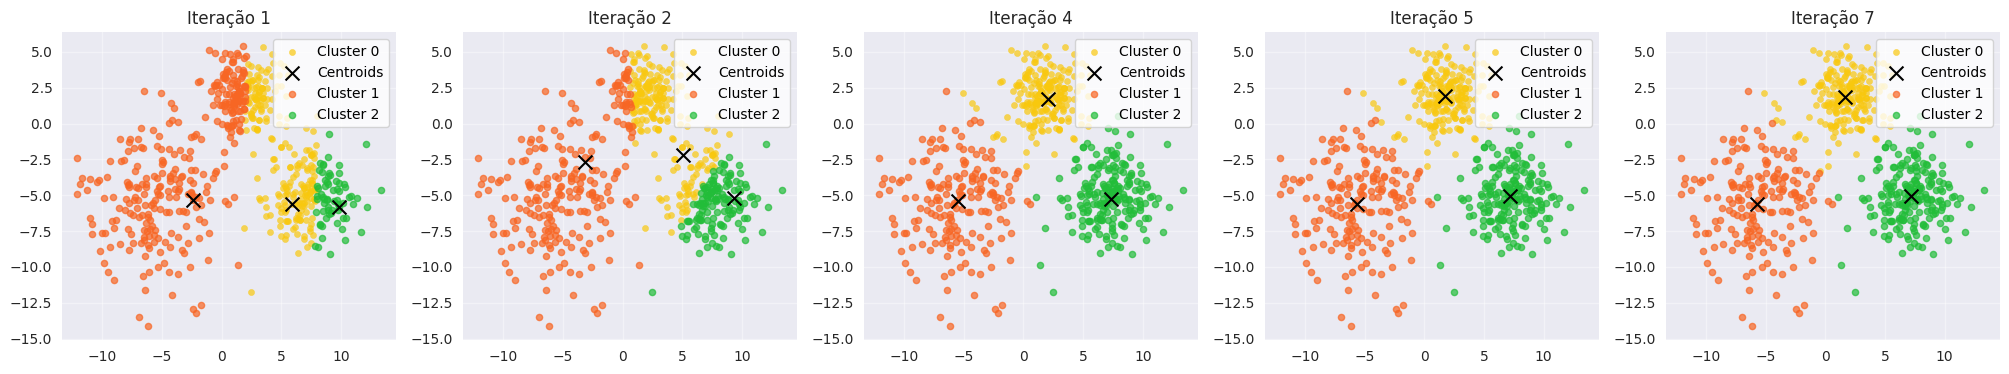

In [20]:
num_iter, centroids, ssd_list = K_means_clustering(X)
_ = K_means_clustering(X, plot_index=[0] + list(np.random.choice(range(1,num_iter-2), size=3, replace=False)) + [num_iter-1])

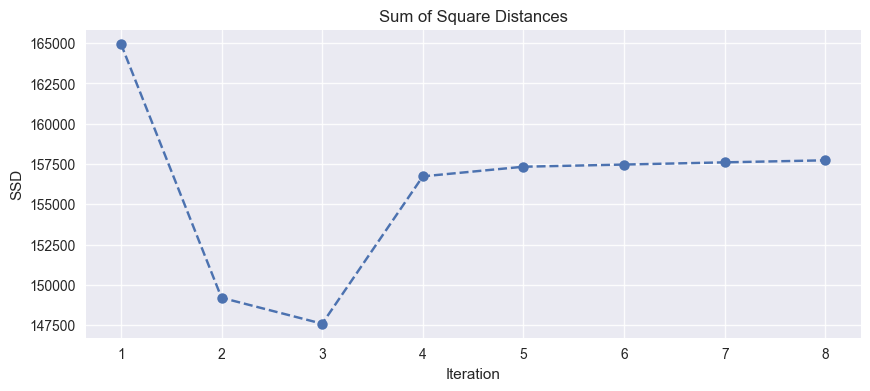

In [21]:
plt.figure(figsize=(10,4))
plt.style.use('seaborn-v0_8')
plt.plot(range(1, num_iter + 2),ssd_list, linestyle='--', marker='.', markersize=15)
plt.title("Sum of Square Distances")
plt.ylabel("SSD")
plt.xlabel("Iteration")
plt.grid(alpha=0.9)
plt.show()